<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2024/blob/main/Harmonic_Oscilator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [21]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true)**2)

    # Physics loss
    y_pred.requires_grad_(True)
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    physics_loss = torch.mean((y_tt + y_pred)**2)  # Simple harmonic oscillator: y'' + y = 0

    return data_loss + physics_loss

In [23]:
# Generate synthetic data
np.random.seed(42)
t = np.linspace(0, 10, 100)
true_y = np.sin(t)  # True solution for simple harmonic oscillator

# Initial conditions
x0 = torch.tensor([0.0], requires_grad=True).unsqueeze(0)
y0 = torch.tensor([0.0], requires_grad=True).unsqueeze(0)

# Convert to PyTorch tensors
t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(true_y, dtype=torch.float32).unsqueeze(1)

In [24]:
# Initialize the model, optimizer, and loss function
input_dim = 1
hidden_dim = 20
output_dim = 1
model = PINN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Ensure that t_tensor requires gradients
    t_tensor.requires_grad_(True)

    # Forward pass
    y_pred = model(t_tensor)

    # Compute the loss
    loss = loss_function(model, t_tensor, y_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/20000], Loss: 0.3161
Epoch [200/20000], Loss: 0.2528
Epoch [300/20000], Loss: 0.2393
Epoch [400/20000], Loss: 0.2390
Epoch [500/20000], Loss: 0.2385
Epoch [600/20000], Loss: 0.2384
Epoch [700/20000], Loss: 0.2385
Epoch [800/20000], Loss: 0.2384
Epoch [900/20000], Loss: 0.2385
Epoch [1000/20000], Loss: 0.2387
Epoch [1100/20000], Loss: 0.2389
Epoch [1200/20000], Loss: 0.2384
Epoch [1300/20000], Loss: 0.2384
Epoch [1400/20000], Loss: 0.2385
Epoch [1500/20000], Loss: 0.2388
Epoch [1600/20000], Loss: 0.2393
Epoch [1700/20000], Loss: 0.2385
Epoch [1800/20000], Loss: 0.2384
Epoch [1900/20000], Loss: 0.2546
Epoch [2000/20000], Loss: 0.2384
Epoch [2100/20000], Loss: 0.2383
Epoch [2200/20000], Loss: 0.2385
Epoch [2300/20000], Loss: 0.2388
Epoch [2400/20000], Loss: 0.2382
Epoch [2500/20000], Loss: 0.2381
Epoch [2600/20000], Loss: 0.2378
Epoch [2700/20000], Loss: 0.2412
Epoch [2800/20000], Loss: 0.2378
Epoch [2900/20000], Loss: 0.2378
Epoch [3000/20000], Loss: 0.2386
Epoch [3100/20000],

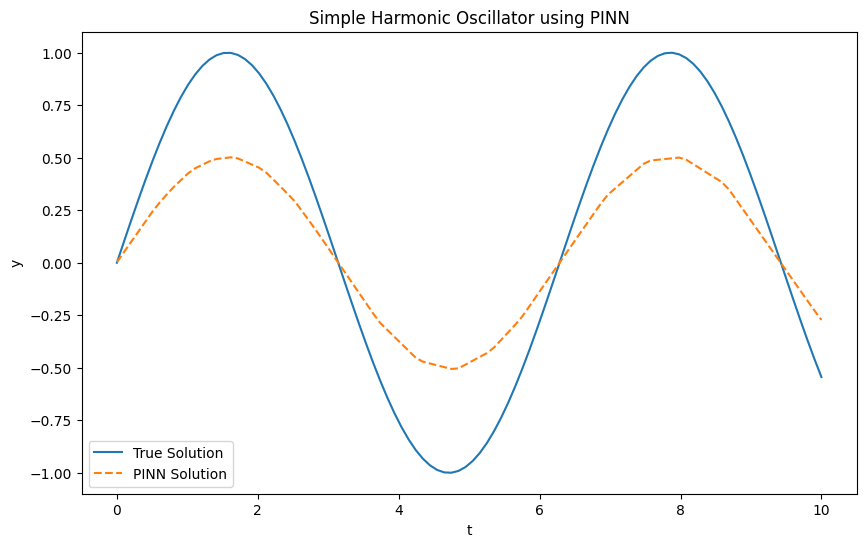

In [25]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(t_tensor)

# Convert to numpy arrays
y_pred = y_pred.squeeze().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, true_y, label='True Solution')
plt.plot(t, y_pred, label='PINN Solution', linestyle='--')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Simple Harmonic Oscillator using PINN')
plt.legend()
plt.show()